In [1]:
SensorNum=1 # Sensor number
WindowWidth=[128,256,512,1024,2048,4096] # Window Width
OverlapArray=[32,32,32,32,32,32] # sliding window
#width=1000 # graph width 
#EncodingDim=[4,8,12,16,32,64] # number of hidden layer note
encoding_dim=16
Axis='AccZ' # Axis

#WORKSPACE_PATH = "/media/takeyama/HD-PZU3/01_TAKEYAMA_WORKSPACE/02_CommonData"
WORKSPACE_PATH = "/home/takeyama/Documents/01_SyncChopin"
DATE_PATH="/2016-08-15/"
TITLE_PATH="Optim/"

In [2]:
import numpy as np
import pandas as pd
from scipy import fftpack
from scipy import signal
import time
import os
import matplotlib.pyplot as plt
import pylab
import pickle
import copy

import processing
import window

import matplotlib.animation as animation
import datetime

%matplotlib inline

In [3]:
from keras.models import Sequential
from keras.datasets import cifar10
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import SGD, Adadelta, Adagrad, Adam, Adamax, RMSprop, Nadam
from keras.utils import np_utils
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils.visualize_util import model_to_dot, plot
from keras import backend as K
from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import EarlyStopping

import matplotlib.image as mpimg


Using Theano backend.
Using gpu device 0: GeForce GTX 970 (CNMeM is disabled, cuDNN 4007)


In [4]:
DataName='sensor'+str(SensorNum)+'_'+Axis
SensorName='sensor'+str(SensorNum)
DicName='MemSensor'+str(SensorNum)

In [5]:
# define rawdata directory
if not os.path.exists(WORKSPACE_PATH+"/raw/"):
    os.makedirs(WORKSPACE_PATH+"/raw/")
RawDataPath=WORKSPACE_PATH+"/raw/"

# define restoring windowdata directory
if not os.path.exists(WORKSPACE_PATH+'/window/'+TITLE_PATH+DataName+'/'): 
    os.makedirs(WORKSPACE_PATH+'/window/'+TITLE_PATH+DataName+'/')
WindowDataPath=WORKSPACE_PATH+'/window/'+TITLE_PATH+DataName+'/'

# define restoring netowrk model picture's directory
if not os.path.exists(WORKSPACE_PATH+DATE_PATH+'/modelPic/'+TITLE_PATH+DataName+'/'): 
    os.makedirs(WORKSPACE_PATH+DATE_PATH+'/modelPic/'+TITLE_PATH+DataName+'/')
StudyDataModelPicPath=WORKSPACE_PATH+DATE_PATH+'/modelPic/'+TITLE_PATH+DataName+'/'

# define restoring graph data's directory
if not os.path.exists(WORKSPACE_PATH+DATE_PATH+'/graph/'+TITLE_PATH+DataName+'/Edim=16-Ol=32/'): 
    os.makedirs(WORKSPACE_PATH+DATE_PATH+'/graph/'+TITLE_PATH+DataName+'/Edim=16-Ol=32/')
GraphDataPath=WORKSPACE_PATH+DATE_PATH+'/graph/'+TITLE_PATH+DataName+'/Edim=16-Ol=32/'

# define restoring model paarmeter directory
if not os.path.exists(WORKSPACE_PATH+DATE_PATH+'/study/'+TITLE_PATH+DataName+'/'): 
    os.makedirs(WORKSPACE_PATH+DATE_PATH+'/study/'+TITLE_PATH+DataName+'/')
StudyDataPath=WORKSPACE_PATH+DATE_PATH+'/study/'+TITLE_PATH+DataName+'/'

**Phase1 計測データの取得**

In [6]:
dic=processing.LoadDicDataFromFileNPZ(RawDataPath+DicName)

**Phase2 window flame 作成 & Learning**

In [7]:
optimizers = [SGD, Adadelta, Adamax, Adam, Adagrad,  RMSprop, Nadam]
optimArray = ["SGD", "Adadelta","Adamax", "Adam", "Adagrad","RMSprop","Nadam"]

hiden node = 16
-edim=16-Window=128-Overlap=32-SGD
Graph range=0 : 50924
Graph range=50924 : 101848
Graph range=101848 : 152772
Graph range=152772 : 203696
Graph range=203696 : 254620
Graph range=254620 : 305544
Graph range=305544 : 356468
Graph range=356468 : 407392
Graph range=407392 : 458316
Graph range=458316 : 509240
Graph range=509240 : 560164
Graph range=560164 : 611088
Graph range=611088 : 662012
Graph range=662012 : 712936
Graph range=712936 : 763860
Graph range=763860 : 814784
Graph range=814784 : 865708
Graph range=865708 : 916632
Graph range=916632 : 967556
Graph range=967556 : 1018480
hiden node = 16
-edim=16-Window=128-Overlap=32-Adadelta
Graph range=0 : 50924
Graph range=50924 : 101848
Graph range=101848 : 152772
Graph range=152772 : 203696
Graph range=203696 : 254620
Graph range=254620 : 305544
Graph range=305544 : 356468
Graph range=356468 : 407392
Graph range=407392 : 458316
Graph range=458316 : 509240
Graph range=509240 : 560164
Graph range=560164 : 611088
Graph rang

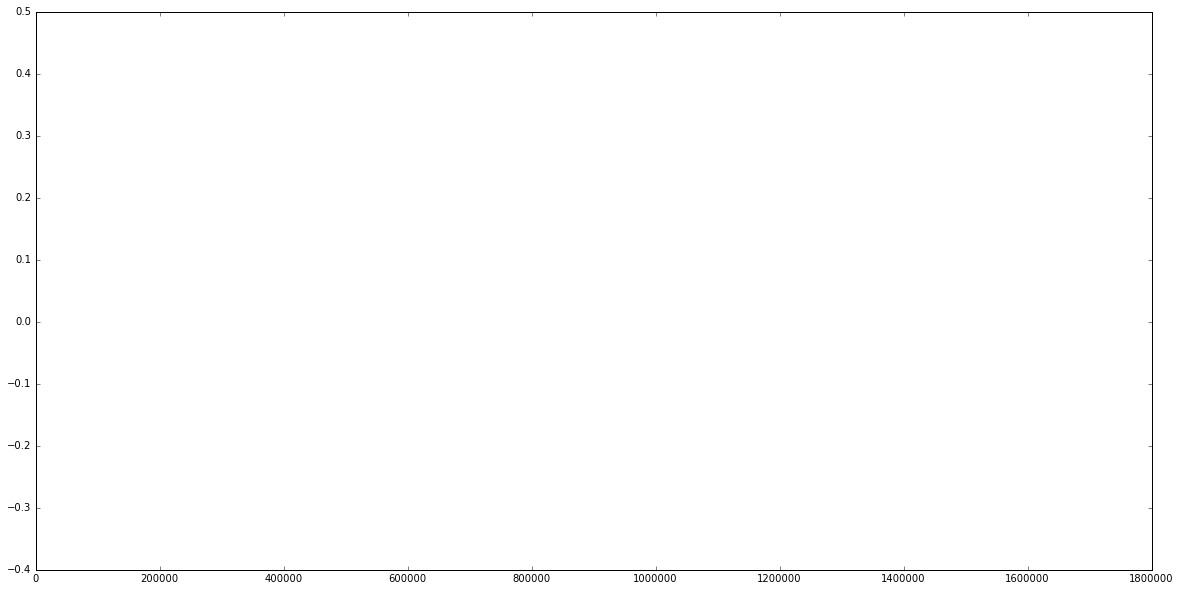

In [8]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

# loop windowWidth
for SampleNum,Overlap in zip(WindowWidth,OverlapArray): 
    for opt,optName in zip(optimizers,optimArray):
        print "hiden node = "+str(encoding_dim)
        CommonName='-edim='+str(encoding_dim)+'-Window='+str(SampleNum)+'-Overlap='+str(Overlap)+'-'+optName
        print CommonName
        SaveFileNameEncord=DataName+'_encoded'+CommonName
        SaveFileNameDecord=DataName+'_decoded'+CommonName
        SaveFileNameNet=DataName+'_net'+CommonName
        SaveFileNameTrain=DataName+'_train'+CommonName
        SaveFileNameTest=DataName+'_test'+CommonName
        SaveFileNameGraph=GraphDataPath+DataName+CommonName

        window_train=processing.LoadDicDataFromFileNPZ(WindowDataPath+SaveFileNameTrain)
        #window_test=processing.LoadDicDataFromFileNPZ(WindowDataPath+SaveFileNameTest)
        #encoded_imgs = processing.LoadDicDataFromFileNPZ(StudyDataPath+SaveFileNameEncord)
        decoded_imgs = processing.LoadDicDataFromFileNPZ(StudyDataPath+SaveFileNameDecord)
        
        length_Raw = window_train.shape[0]*window_train.shape[1]
        length_Rec = decoded_imgs.shape[0]*decoded_imgs.shape[1]
        
        window_train = window_train.reshape(length_Raw,1)
        decoded_imgs = decoded_imgs.reshape(length_Rec,1)
        
        width = length_Raw/20
        for i in range(width,length_Raw,width):
            start =i-width 
            goal=i

            dataE = window_train[start:goal]
            dataD = decoded_imgs[start:goal]
            
            ax.plot(range(0,len(dataE)),dataE,'r',label="raw data")
            ax.plot(range(0,len(dataD)),dataD,'b',label="reconstruct")
            ax.legend(loc='best',fontsize=10)
            ax.set_title(str(start)+"-"+str(goal))
            ax.figure.savefig(SaveFileNameGraph+'-'+str(start)+"-"+str(goal)+'-graph')
            ax.clear()
            print 'Graph range='+str(start)+' : '+str(goal)

In [9]:
print "finish"

finish
